In [37]:
import os
from sklearn.linear_model import PoissonRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error 
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import poisson
from scipy.stats import nbinom
from patsy import dmatrices
os.chdir(os.path.expanduser("~/Misc/Research/deep_uncertainty"))
from deep_uncertainty.evaluation.calibration import compute_mean_calibration

In [38]:
# bikes = pd.read_csv('deep_uncertainty/datalocal/hour.csv')
# bikes = bikes[:1000]

sales_data_loc = 'deep_uncertainty/datalocal/ccount.sas7bdat'
sales_data  = pd.read_sas(sales_data_loc)
#deal with Nan values
sales_data = sales_data.dropna()
sales_data['CUSTCOUN'] = sales_data['CUSTCOUN'] // 1
sales_data['CUSTCOUN'] = sales_data['CUSTCOUN'].astype(int)
sales_data = sales_data[sales_data['CUSTCOUN'] > 0]
sales_data = sales_data[:1000]
sales_data.columns

Index(['STORE', 'DATE', 'GROCERY', 'DAIRY', 'FROZEN', 'BOTTLE', 'MVPCLUB',
       'GROCCOUP', 'MEAT', 'MEATFROZ', 'MEATCOUP', 'FISH', 'FISHCOUP', 'PROMO',
       'PROMCOUP', 'PRODUCE', 'BULK', 'SALADBAR', 'PRODCOUP', 'BULKCOUP',
       'SALCOUP', 'FLORAL', 'FLORCOUP', 'DELI', 'DELISELF', 'DELIEXPR',
       'CONVFOOD', 'CHEESE', 'DELICOUP', 'BAKERY', 'PHARMACY', 'PHARCOUP',
       'GM', 'JEWELRY', 'COSMETIC', 'HABA', 'GMCOUP', 'CAMERA', 'PHOTOFIN',
       'VIDEO', 'VIDEOREN', 'VIDCOUP', 'BEER', 'WINE', 'SPIRITS', 'MISCSCP',
       'MANCOUP', 'CUSTCOUN', 'FTGCHIN', 'FTGCCOUP', 'FTGITAL', 'FTGICOUP',
       'DAIRCOUP', 'FROZCOUP', 'HABACOUP', 'PHOTCOUP', 'COSMCOUP', 'SSDELICP',
       'BAKCOUP', 'LIQCOUP', 'WEEK'],
      dtype='object')

In [39]:
sales_data = sales_data.drop(['DATE'], axis=1)
X = sales_data.iloc[:,:-1]
mask = np.random.rand(len(sales_data)) < 0.8
df_train = sales_data[mask]
df_test = sales_data[~mask]

expr = "CUSTCOUN ~ " + " + ".join(sales_data.columns[:-1])
expr

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
poisson_testing_results = sm.GLM(y_test, X_test, family=sm.families.Poisson()).fit()
# print(poisson_training_results.summary())

In [40]:
y_preds = poisson_testing_results.mu
posterior_predictive = poisson(mu=y_preds)
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]

array([[1750., 2018.],
       [3847., 4240.],
       [2059., 2349.],
       [1723., 1989.],
       [1726., 1992.],
       [1725., 1992.],
       [1838., 2113.],
       [2424., 2738.],
       [1819., 2092.],
       [1812., 2085.]])

In [41]:
y_test[:10].values

array([[1902.],
       [3886.],
       [2217.],
       [1833.],
       [1854.],
       [1846.],
       [1996.],
       [2582.],
       [1967.],
       [1950.]])

In [42]:
sales_data['CUSTCOUN'].mean()

2083.613

In [43]:
sales_data['CUSTCOUN'].std()

511.19127902846185

In [44]:
# Poisson calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.46474981412958094

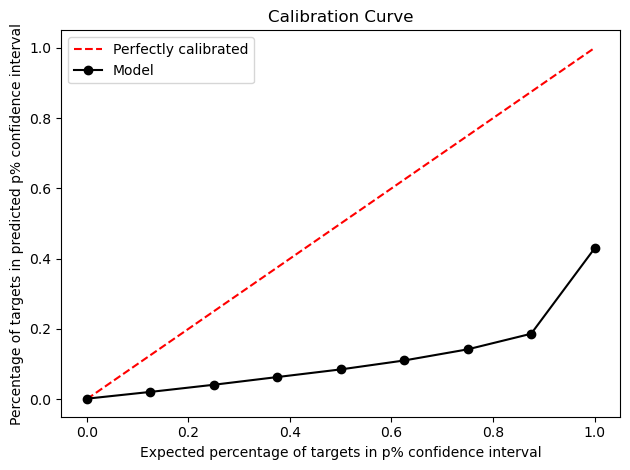

In [45]:
from deep_uncertainty.evaluation.calibration import plot_regression_calibration_curve


plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)

In [46]:
df_train["BB_LAMBDA"] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['CUSTCOUN'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
nb2_predictions = nb2_training_results.get_prediction(X_test)
successes = nb2_training_results.predict(X_test, linear=True)
predictions_summary_frame = nb2_predictions.summary_frame()
predicted_counts=predictions_summary_frame['mean']

/var/folders/d7/8mpnc7h57hb6gcv3lp21z67m0000gn/T/ipykernel_57443/1859759774.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["BB_LAMBDA"] = poisson_training_results.mu
/var/folders/d7/8mpnc7h57hb6gcv3lp21z67m0000gn/T/ipykernel_57443/1859759774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['CUSTCOUN'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
/var/folders/d7/8mpnc7h57hb6gcv3lp21z67m0000gn/T/ipykernel_57443/1859759

In [47]:
y_preds = predicted_counts
y_test = y_test['CUSTCOUN']
# n is # of successes
n = successes
# p is the probability of success
p = successes / len(y_test)
posterior_predictive = nbinom(p=p, n=n)

In [48]:
# Negative Binomial calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.33333333333333337

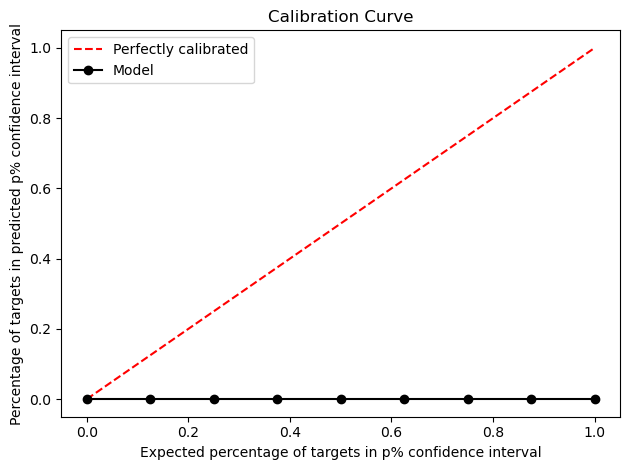

In [49]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)